In [1]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate, interp
from collections import OrderedDict
import scipy.integrate as integrate

matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=3,
                            logzsol=0.0,dust_type=2,dust1=0.0,dust2=0.2,zred=3.0,add_igm_absorption=True)

ages = np.linspace(0,1.0,10) # in Gyr
sfr_ages = np.ones(len(ages))*5.0 # 5 Msol/age bin ... setting the constant sfr = 5 Msun/year

sp.set_tabular_sfh(ages, sfr_ages)

In [3]:
age = 0.5 #Gyr
c = 2.99792458e10 #cm/s
z = 3 # redshift

fsps_filters = []
fsps_filters.append(fsps.get_filter('wfc_acs_f435w'))
fsps_filters.append(fsps.get_filter('wfpc2_f606w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f775w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f850lp'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f105w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f125w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f160w'))
fsps_filters.append(fsps.get_filter('jwst_f200w'))
fsps_filters.append(fsps.get_filter('jwst_f277w'))
fsps_filters.append(fsps.get_filter('jwst_f356w'))
fsps_filters.append(fsps.get_filter('jwst_f444w'))
print(fsps_filters)

z3_mags = sp.get_mags(tage=age, bands=[f.name for f in fsps_filters])
print(z3_mags)

# Spectrum in terms of L_sol/AA
wave, spec = sp.get_spectrum(tage=age, peraa=True)

[<Filter(wfc_acs_f435w)>, <Filter(wfpc2_f606w)>, <Filter(wfc3_uvis_f775w)>, <Filter(wfc3_uvis_f850lp)>, <Filter(wfc3_ir_f105w)>, <Filter(wfc3_ir_f125w)>, <Filter(wfc3_ir_f160w)>, <Filter(jwst_f200w)>, <Filter(jwst_f277w)>, <Filter(jwst_f356w)>, <Filter(jwst_f444w)>]
[26.48553913 25.76035159 25.68076576 25.67298217 25.70807518 25.70423185
 25.35301391 25.10535654 25.10094118 24.95894819 24.93217186]


In [4]:
## Compute luminosity distance
omega_M = 0.27
omega_lambda = 0.73
h_0 = (72.0/3.086e+19) # per sec
hubble_d = (c/h_0) # in cm

def recip_E(z):
    return 1.0/np.sqrt(omega_M*(1+z)**3 + omega_lambda)

factor = integrate.quad(recip_E, 0, 3.0)
co_moving_dist = (factor[0] * hubble_d)
lum_dist = (1.0 + z)*co_moving_dist
print("D_L: %s [cm]" % lum_dist)

D_L: 7.86580192794533e+28 [cm]


## Convert units to [erg s^-1 cm^-2 AA^-1]

In [5]:
# via Ned Wright's cosmology calculator: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# z=3 => 25924.2 Mpc => 25924.2e+6 pc => ~ 8e+28 cm
# D = 8e+28 # cm
erg_per_L_sol = 3.828e+33 # erg * s^-1
flux_factor = erg_per_L_sol/(4*np.pi*lum_dist**2)
# jansky = 1e-23 # erg * s^-1 * cm^-2 * Hz

# Window the spectra
indices = np.where((wave >= 0) & (wave <= 60000))[0]
useWave, useSpec = wave[indices], spec[indices]

fluxSpec = useSpec * flux_factor

colors = ["purple","blue","cyan","green", "red", "brown", "black", "red", "green", "cyan", "blue"]

## Convert [erg s^-1 cm^-2 AA^-1] to micro janskys

In [6]:
# Convert wavelength to z=3
z3_wave = useWave * (z+1)

# See: https://en.wikipedia.org/wiki/AB_magnitude#Expression_in_terms_of_f%CE%BB
flux_janskys = []
for i,lam in enumerate(z3_wave):
    f_v = 3.34e+04*(lam**2)*fluxSpec[i]
    flux_janskys.append(f_v)
    
# Convert jansky to microjansky
flux_microjanskys = np.asarray(flux_janskys)*1e+6

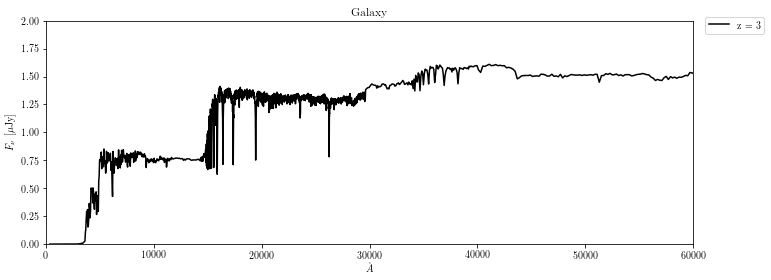

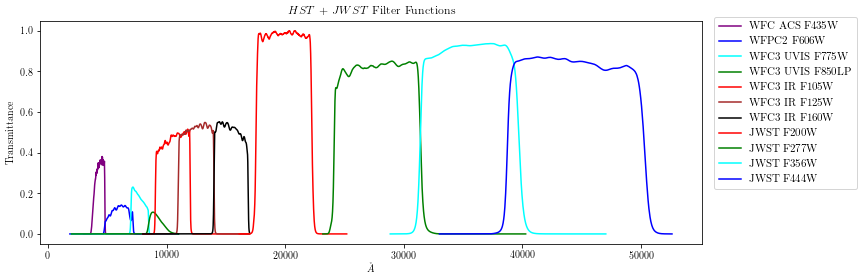

In [7]:
fig = plt.figure(figsize=(10, 4)) 
plt.plot(z3_wave,flux_microjanskys,color='k',label="z = 3")
plt.title("Galaxy")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$F_{\nu}$  [$\mu$Jy]")
plt.xlim([0,60000])
plt.ylim([0,2])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)
plt.tight_layout()    
plt.show()


fig = plt.figure(figsize=(10, 4)) 
for i,f in enumerate(fsps_filters):
    plt.plot(f.transmission[0],f.transmission[1],color=colors[i],label=f.name.replace('_',' ').upper())


plt.title("$HST$ + $JWST$ Filter Functions")
plt.xlabel(r"$\AA$")
plt.ylabel("Transmittance")
# plt.xlim([0,60000])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)

plt.tight_layout()    
plt.show()

In [8]:
z3_bandpass_fluxes = OrderedDict()
filter_funcs = []
for f in fsps_filters:
    filter_func = interp(z3_wave, f.transmission[0], f.transmission[1])
    filter_funcs.append(filter_func)
    z3_bandpass_fluxes[f.name] = filter_func*flux_microjanskys

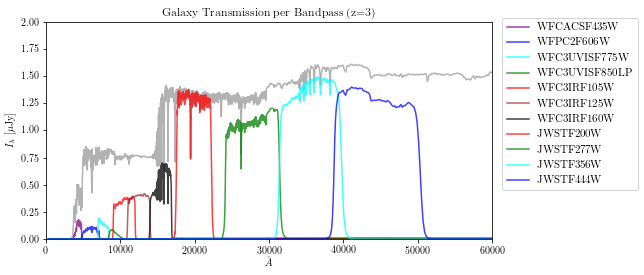

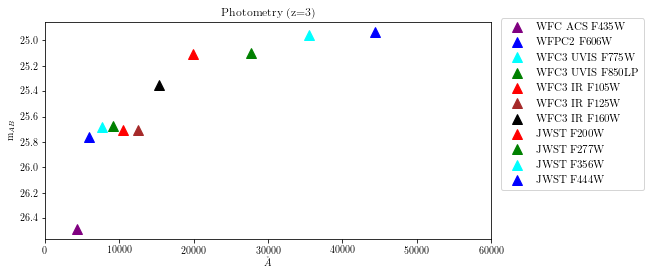

In [9]:
fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(z3_wave,flux_microjanskys,color='k',alpha=0.3)
plt.xlim([0,60000])
plt.ylim([0,2.0])

# Overplot flux through each bandpass
i = 0
for name,value in z3_bandpass_fluxes.items():
    plt.plot(z3_wave,value,color=colors[i],label=name.replace('_','').upper(),alpha=0.75)    
    i+=1
    
plt.title("Galaxy Transmission per Bandpass (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)
plt.xlim([0,60000])
plt.show()

fig = plt.figure(figsize=(8, 4)) 

for i,m in enumerate(z3_mags):
    plt.plot(fsps_filters[i].lambda_eff,m,'^',markersize=10,color=colors[i], label=fsps_filters[i].name.replace('_',' ').upper())
    
plt.title("Photometry (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,60000])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()

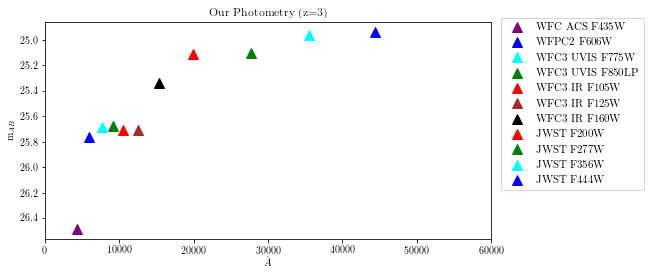

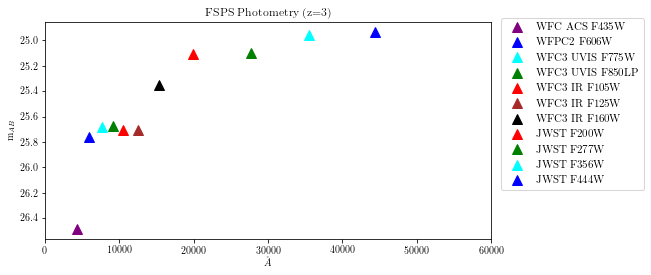

[26.4867044029537, 25.76192705820886, 25.682352918986542, 25.673651760029724, 25.70928496499018, 25.705538384180613, 25.340464070834557, 25.10803066363223, 25.102300851452593, 24.961715244147435, 24.93394696703927]
[26.48553913 25.76035159 25.68076576 25.67298217 25.70807518 25.70423185
 25.35301391 25.10535654 25.10094118 24.95894819 24.93217186]


In [10]:
# Compute our own photometry

def AB(fluxes, wavelengths, transmission_spectrum):
    c = 3.00e1
    scaled_fluxes = np.asarray(fluxes)/(1.0 + z)
    top = np.trapz(scaled_fluxes * transmission_spectrum / wavelengths, x=wavelengths)
    bottom = np.trapz(3631 * transmission_spectrum / wavelengths, x=(wavelengths))
    return -2.5*np.log10( top / bottom )

def ABmagnitude(wave,flux):
    bandpass_mag = []

    for f in filter_funcs:
        bandpass_mag.append(AB(flux,wave,f)  )
        
    return bandpass_mag

f = open('part1_magData.txt','w')
bpm = ABmagnitude(z3_wave,flux_janskys)
fig = plt.figure(figsize=(8, 4)) 
for i,m in enumerate(bpm):
    filterName = fsps_filters[i].name.replace('_',' ').upper()
    plt.plot(fsps_filters[i].lambda_eff,m,'^',markersize=10,color=colors[i], label=filterName)
    f.write('%s\t%f\t%f\n'%(fsps_filters[i].name.upper(),fsps_filters[i].lambda_eff,m))
f.close()

plt.title("Our Photometry (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,60000])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()

################

fig = plt.figure(figsize=(8, 4)) 
for i,m in enumerate(z3_mags):
    plt.plot(fsps_filters[i].lambda_eff,m,'^',markersize=10,color=colors[i], label=fsps_filters[i].name.replace('_',' ').upper())
    
plt.title("FSPS Photometry (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,60000])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()

# Check
print(bpm)
print(z3_mags)